In [224]:
import functools
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import rebound
from scipy import constants
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline
import matplotlib.pyplot as plt

from code.fitting.analytical import bayesian_mvn_regression_fit
from code.utils import load_data

In [3]:
earth_radius = 6.378e6  # m
earth_mass = 5.972e24  # kg
solar_radius = 6.957e8 # m
solar_mass = 1.989e30  # kg
jupiter_radius = 69911000 # m
jupiter_mass = 1.898e27 # kg

## Mocking up transit times

Let's mock up some transit times that result from different phenomena and levels of Gaussian noise and examine the false positive rate that arises from fits.

Assume 0 eccentricity throughout.

In [4]:
# Wasp-12b like parameters
T0 = 0
P0 = 1.09 * 24 * 60 * 60 # seconds
dP_dE = -0.05 * 1e-3  # seconds per epoch
Qs = 10**5.5
a = 0.01 * constants.au  # m

SECONDS_TO_DAYS = 60 * 60 * 24

### Models

Output of these models is transit times in days.

In [5]:
def plot_transits(transits, E):
    X = np.vstack([np.ones(len(E)), E]).T
    c, m = np.linalg.lstsq(X, transits, rcond=None)[0]
    computed = m*np.array(E) + c
    deviations = transits-computed

    fig = plt.figure(figsize=(10,5))
    plt.scatter(E, deviations)
    plt.axhline(0, color="orange")
    plt.xlabel("Transit number")
    plt.ylabel("O-C [seconds]")
    plt.show()

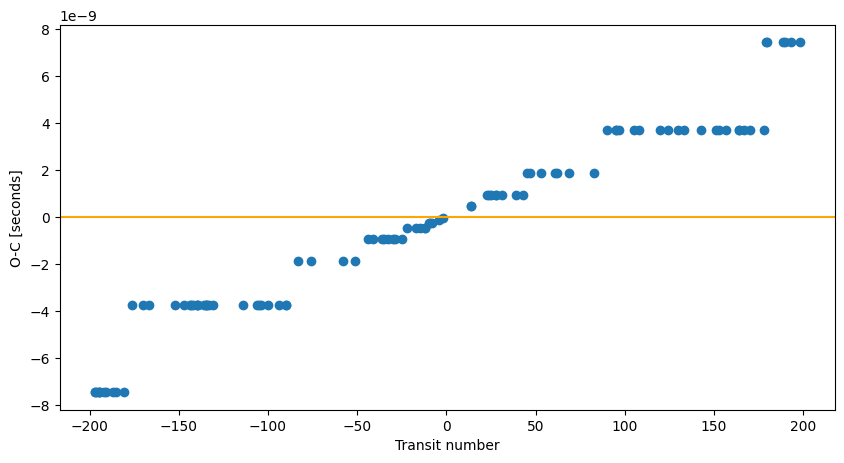

In [6]:
E = np.random.randint(-200, 200, 100) # it's ok to generate two of the same epoch, that would correpsond to two independent observations of the same transit

def quadratic_ephemeris_model(E, T0, P0, dP_dE):
    return T0 + P0 * E + 0.5 * dP_dE * (E**2)

transits = quadratic_ephemeris_model(E, T0, P0, dP_dE=0.)
plot_transits(transits, E)

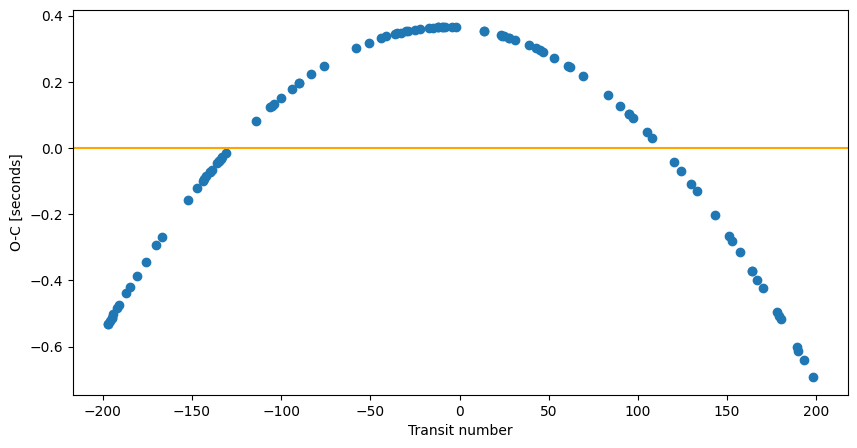

In [7]:
def quadratic_ephemeris_model(E, T0, P0, dP_dE):
    return T0 + P0 * E + 0.5 * dP_dE * (E**2)

transits = quadratic_ephemeris_model(E, T0, P0, dP_dE)
plot_transits(transits, E)

In [7]:
# E = np.random.randint(-200, 200, 100) # it's ok to generate two of the same epoch, that would correpsond to two independent observations of the same transit

# def tidal_decay_model(E, T0, P0):
#     c0 = (4.5*np.sqrt(constants.G/solar_mass)*np.power(solar_radius, 5.0) * jupiter_mass / Qs) / ((2/3)*np.power(constants.G*solar_mass/(4*np.power(np.pi, 2.0)), 13/6))
#     c1 = 0.3 * np.power(P0, 10/3)
#     c2 = 0.697*c0*T0 - 0.769*np.power(c1, 1.3)
#     return -(1.435/c0)*(0.769*np.power((c0*E+c1), 1.3) + c2)

# transits = tidal_decay_model(E, T0, P0)
# plot_transits(transits, E)

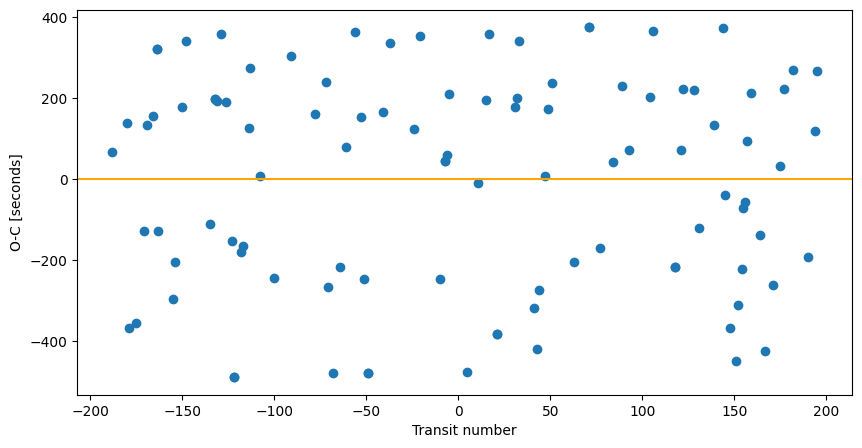

In [346]:
E = np.random.randint(-200, 200, 100) # it's ok to generate two of the same epoch, that would correpsond to two independent observations of the same transit

def companion_planet_model(E):
    sim = rebound.Simulation()
    sim.add(m=1)  # star
    sim.add(m=1e-5, a=0.6,e=0.)
    sim.add(m=1e-6, a=0.5, e=0.)
    
    sim.move_to_com()
    
    # timestep of 2*pi = 1 Earth-like orbit if mass = solar mass and a = earth semi-major axis i.e. 1 AU
    timestep_to_seconds = 365 * 24 * 60 * 60 / (2*np.pi)
    integrate_timestep = 12 * 60 * 60 / timestep_to_seconds # 12 hours in simulation time units

    # note each call to .integrate is an independent run of the simulation
    E_copy = E + abs(min(E))
    N = max(E_copy) + 1
    transits = np.zeros(N)
    p = sim.particles
    i = 0
    while i < N:
        y_old = p[1].y - p[0].y
        t_old = sim.t
        sim.integrate(sim.t+integrate_timestep) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-9:   # bisect until prec of 1e-7 reached
                if y_old*(p[1].y-p[0].y)<0.:  # if we have crossed the y axis
                    t_new = sim.t
                else:  # if we have not crossed the y axis
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)  # integrate up to halfway between the current time and the new time
            transits[i] = sim.t
            i += 1
            sim.integrate(sim.t+integrate_timestep)       # integrate 0.05 to be past the transit 
    
    return transits[E_copy] * timestep_to_seconds

transits = companion_planet_model(E)
plot_transits(transits, E)

### Tests

The test works as follows:
* generate 100 epochs randomly from a uniform distribution, these are the epochs at which we will mock up observations
* generate transit times at these epochs according to a given model
* add some IID gaussian error to these transit times
* fit the model and record whether it gives a > 95% chance of decay
* repeat 100 times

In [10]:
# WASP-12b
wasp_12 = load_data("./data/ETD/ORIGINALS/ETD_WASP-12_og.txt")
bayesian_mvn_regression_fit(wasp_12, K0=np.diag([1e-12, 1e-12, 1e-12]))

(array([[ 3.80451735e-03],
        [ 1.09141996e+00],
        [-7.04464043e-10]]),
 array([[ 7.13309454e-09,  1.25081214e-12, -4.58267388e-15],
        [ 1.25081214e-12,  1.82701628e-15, -1.17716049e-18],
        [-4.58267388e-15, -1.17716049e-18,  4.83549329e-21]]),
 array([0.00019982, 0.00059943, 0.00156857, 0.0004699 , 0.0010036 ,
        0.00099976, 0.00178105, 0.0009805 , 0.00065938, 0.00149394,
        0.00129661, 0.00044097, 0.00015995, 0.00141042, 0.00131013,
        0.00012161, 0.00016671, 0.00062028, 0.00129256, 0.00205908,
        0.00112434, 0.00087061, 0.00070014, 0.00034968, 0.00038305,
        0.00049958, 0.00134872, 0.00134889, 0.00040142, 0.00069191,
        0.00085038, 0.00082074, 0.00047067, 0.00219955, 0.00041981,
        0.00208815, 0.00108898, 0.00094028, 0.00083828, 0.00078567,
        0.00054626, 0.00172838, 0.00142292, 0.00070973, 0.00070973,
        0.00075351, 0.00125897, 0.00091922, 0.00128885, 0.00168701,
        0.00073097, 0.00063171, 0.00059647, 0.000382

In [9]:
def run_test(model, variances, trials=100, baseline=200):
    probs = []

    for i in range(trials):
        E = np.random.randint(-baseline, baseline, 100)
        transits = model(E)
        error = sp.stats.multivariate_normal(mean=0, cov=sp.stats.Covariance.from_diagonal(variances)).rvs().flatten()
        observations = transits + error
        df = pd.DataFrame(index=E, data={"epoch": E, "transit_time": observations*SECONDS_TO_DAYS, "error": np.sqrt(variances)*SECONDS_TO_DAYS})
        beta, t_sigma, error, k, t_dof, prob_decay, posterior_observation_covariance = bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
        probs.append(prob_decay)
    
    decay_detection_rate_95 = np.count_nonzero(np.array(probs) > 0.95) / len(probs)
    return decay_detection_rate_95

#### How does increasing observational error affect our detection rate?

In this situation we have a WASP-12b like planet and we slowly up the amount of random error we add.

In [13]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = -0.05*1e-3
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(-2, 2, 100):
    test = ({"error_name": "constant_variance_error", "var": var}, np.full(len(E), var)) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, variances, trials=100)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


<AxesSubplot: xlabel='Variance of added error [s^2]', ylabel='Decay detection rate'>

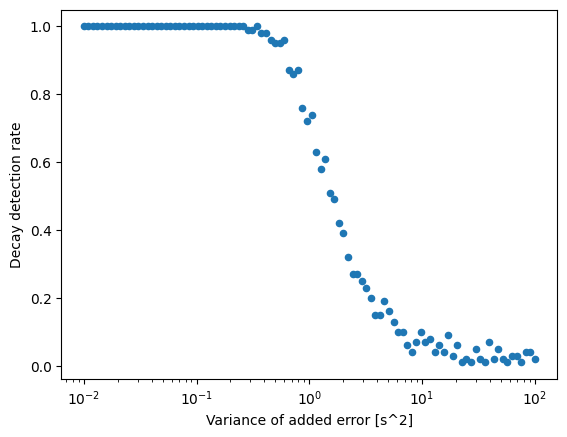

In [14]:
df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Variance of added error [s^2]", ylabel="Decay detection rate")

This should be a clear-cut case of quadratic ephemeris decay, but we don't see that if we start adding random errors on the order of 3s. This is a lot more sensitive to error than I might have thought.

Recall 1 standard deviation ~68% of probability.

In [15]:
np.power(wasp_12.error * 24 * 60 * 60, 2.0)

0        298.598400
1       2687.385600
2      18166.726656
3       1649.009664
4       7464.960000
           ...     
252     1649.009664
253     6737.126400
254     9701.462016
255     9197.577216
256     2176.782336
Name: error, Length: 257, dtype: float64

In [16]:
sp.stats.multivariate_normal(mean=0, cov=sp.stats.Covariance.from_diagonal(np.full(10, 10))).rvs().flatten()

array([-0.80103669, -4.14773518,  1.26430677,  2.71439475, -4.00778773,
       -1.96309011,  4.32811456, -3.50211492, -0.98272491, -0.56216984])

#### What about with a longer transit range?

In [17]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = -0.05*1e-3
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(2, 6, 100):
    test = ({"error_name": "constant_variance_error", "var": var}, np.full(len(E), var)) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, variances, trials=100, baseline=2000)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


<AxesSubplot: xlabel='Variance of added error [s^2]', ylabel='Decay detection rate'>

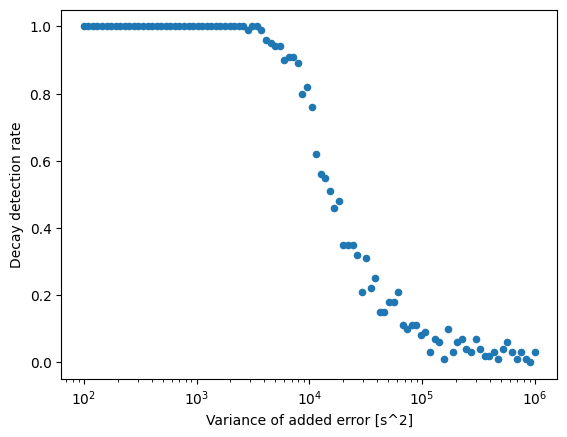

In [18]:
df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Variance of added error [s^2]", ylabel="Decay detection rate")

Over a tenfold increased range of +- 2000 epochs, we have no problem distinguishing decay when the error variance is less than around 10,000, or 100s standard deviation.

In [19]:
np.power(wasp_12.error * 24 * 60 * 60, 2.0)

0        298.598400
1       2687.385600
2      18166.726656
3       1649.009664
4       7464.960000
           ...     
252     1649.009664
253     6737.126400
254     9701.462016
255     9197.577216
256     2176.782336
Name: error, Length: 257, dtype: float64

#### How do different decay rates affect our detection rate?

In [12]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
for dP_dE in np.logspace(-9, -3, 100):
    dP_dE = -dP_dE
    test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": -dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
    MODELS.append(test)

ERRORS = []
var = 10  # seconds^2
test = ({"error_name": "constant_variance_error", "var": var}, np.full(len(E), var)) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, variances, trials=100)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


<AxesSubplot: xlabel='dP/dE [s/epoch]', ylabel='Decay detection rate'>

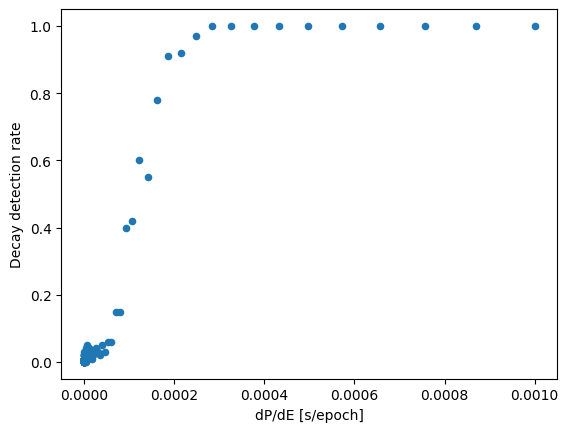

In [21]:
df = pd.DataFrame(data=results)
df.plot.scatter(x="dP_dE", y="decay_detection_rate", logx=False, xlabel="dP/dE [s/epoch]", ylabel="Decay detection rate")

Generally our model is pretty good at picking up on decay 0.1ms of decay with a 10s error variance. Constant or near-constant systems do not get flagged at the 95% significance level very often.

#### What about different models?

In [375]:
def full_companion_planet_model(N=400, m2=1e-4, a2=0.2, e2=0.1):
    star_idx = 0
    planet_idx = 1
    sim = rebound.Simulation()
    sim.add(m=1)  # star
    sim.add(m=1e-3, a=0.01,e=0.0)
    sim.add(m=m2, a=a2, e=e2)

    sim.move_to_com()

    # timestep of 2*pi = 1 Earth-like orbit if mass = solar mass and a = earth semi-major axis i.e. 1 AU
    # time unit = 365 * 24 * 60 * 60 / (2*np.pi) = 58.09 days
    timestep_to_seconds = 365 * 24 * 60 * 60 / (2*np.pi)
    integrate_timestep = 2 * 24 * 60 * 60 / timestep_to_seconds # 4 hours in simulation time units

    # note each call to .integrate is an independent run of the simulation
    transits = np.zeros(N)
    p = sim.particles
    i = 0
    while i < N:
        y_old = p[planet_idx].y - p[star_idx].y
        t_old = sim.t
        sim.integrate(sim.t+integrate_timestep) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p[planet_idx].y-p[star_idx].y)<0. and p[planet_idx].x-p[star_idx].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-9:   # bisect until prec of 1e-7 reached
                if y_old*(p[planet_idx].y-p[star_idx].y)<0.:  # if we have crossed the y axis
                    t_new = sim.t
                else:  # if we have not crossed the y axis
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)  # integrate up to halfway between the current time and the new time
            transits[i] = sim.t
            i += 1
            sim.integrate(sim.t+integrate_timestep)       # integrate 0.05 to be past the transit 
    
    return transits * timestep_to_seconds

def run_companion_test(model, variances, trials=100):
    all_transits = model(N=201)
    
    probs = []
    for i in range(trials):
        E = np.random.randint(0, 200, 100)
        transits = all_transits[E]
        error = sp.stats.multivariate_normal(mean=0, cov=sp.stats.Covariance.from_diagonal(variances)).rvs().flatten()
        observations = transits + error
        df = pd.DataFrame(index=E, data={"epoch": E, "transit_time": observations*SECONDS_TO_DAYS, "error": np.sqrt(variances)*SECONDS_TO_DAYS})
        beta, t_sigma, error, k, t_dof, prob_decay, *_ = bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
        probs.append(prob_decay)
    
    decay_detection_rate_95 = np.count_nonzero(np.array(probs) > 0.95) / len(probs)
    return decay_detection_rate_95


MODELS = []
for m2 in np.logspace(-6, -3, 8):
    for a2 in np.linspace(0.01, 0.1, 8):
        for e2 in np.linspace(0.0, 0.3, 8):
            test = ({"model_name": "companion_planet_model", "m2": m2, "a2": a2, "e2": e2}, functools.partial(full_companion_planet_model, m2=m2, a2=a2, e2=e2))
            MODELS.append(test)

ERRORS = []
var = 10
test = ({"error_name": "constant_variance_error", "var": var}, np.full(100, var)) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_companion_test(model, variances, trials=100)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

In [376]:
companion_results_2 = results

In [377]:
df = pd.DataFrame(data=companion_results_2)
df

model_name        m2    a2        e2  \
0    companion_planet_model  0.000001  0.01  0.000000   
1    companion_planet_model  0.000001  0.01  0.042857   
2    companion_planet_model  0.000001  0.01  0.085714   
3    companion_planet_model  0.000001  0.01  0.128571   
4    companion_planet_model  0.000001  0.01  0.171429   
..                      ...       ...   ...       ...   
251  companion_planet_model  0.000019  0.10  0.128571   
252  companion_planet_model  0.000019  0.10  0.171429   
253  companion_planet_model  0.000019  0.10  0.214286   
254  companion_planet_model  0.000019  0.10  0.257143   
255  companion_planet_model  0.000019  0.10  0.300000   

                  error_name  var  decay_detection_rate  
0    constant_variance_error   10                  0.99  
1    constant_variance_error   10                  0.00  
2    constant_variance_error   10                  0.02  
3    constant_variance_error   10                  0.80  
4    constant_variance_error   10                  1.00  
..                       ...  ...                   ...  
251  constant_variance_error   10                  0.01  
252  constant_variance_error   10                  0.01  
253  constant_variance_error   10                  0.00  
254  constant_variance_error   10                  0.02  
255  constant_variance_error   10                  0.00  

[256 rows x 7 columns]

<AxesSubplot: xlabel='Mass of second planet [Solar masses]', ylabel='Decay detection rate'>

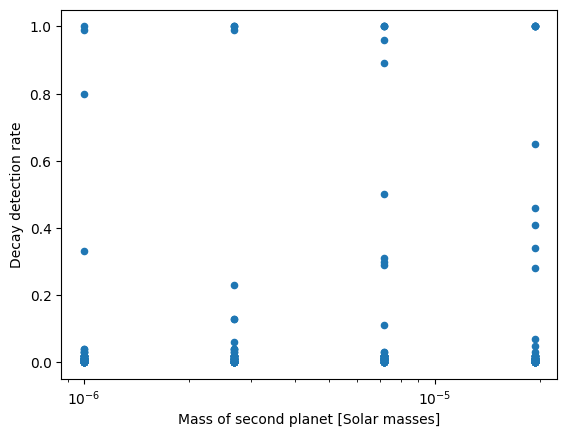

In [378]:
df = pd.DataFrame(data=companion_results_2)
df.plot.scatter(x="m2", y="decay_detection_rate", logx=True, xlabel="Mass of second planet [Solar masses]", ylabel="Decay detection rate")

<AxesSubplot: xlabel='Semi-major axis of second planet [AU]', ylabel='Decay detection rate'>

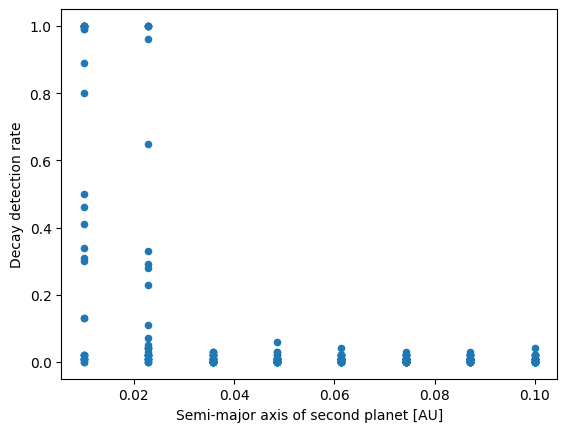

In [379]:
df = pd.DataFrame(data=companion_results_2)
df.plot.scatter(x="a2", y="decay_detection_rate", logx=False, xlabel="Semi-major axis of second planet [AU]", ylabel="Decay detection rate")

<AxesSubplot: xlabel='Eccentricity of second planet', ylabel='Decay detection rate'>

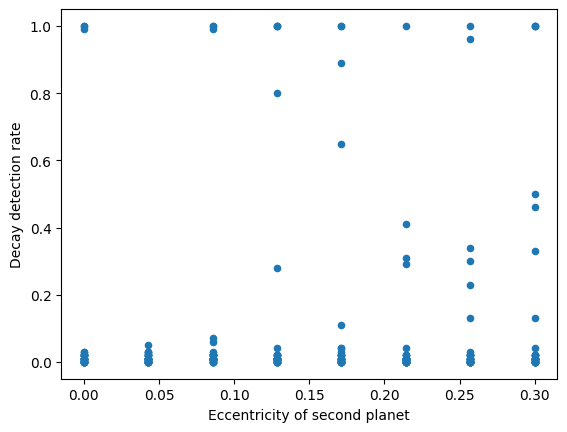

In [380]:
df = pd.DataFrame(data=companion_results_2)
df.plot.scatter(x="e2", y="decay_detection_rate", logx=False, xlabel="Eccentricity of second planet", ylabel="Decay detection rate")

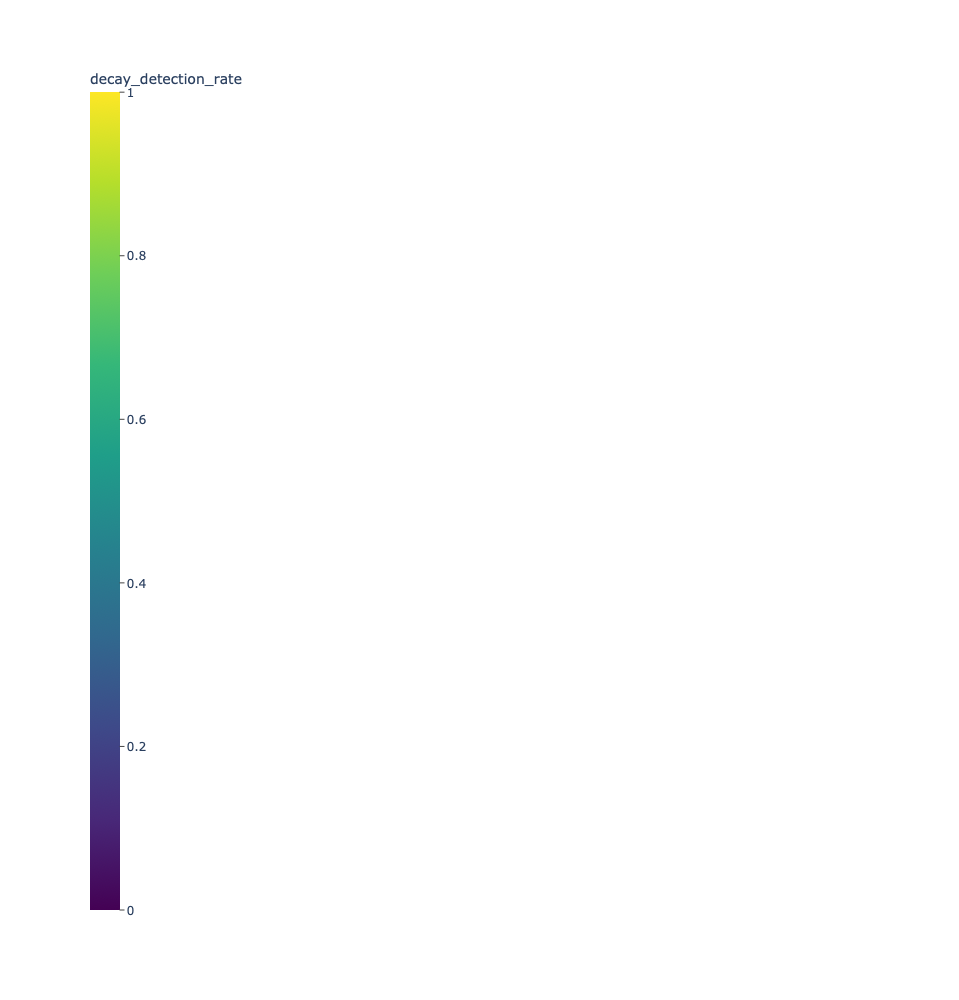

In [381]:
labels = {"a2": "Semi-major axis [au]", "m2": "Mass [Solar masses]", "e2": "Eccentricity"}
fig = px.scatter_3d(companion_results_2, x="m2", y="a2", z="e2",
                    color="decay_detection_rate", color_continuous_scale=px.colors.sequential.Viridis, 
                    log_x=True, log_y=False, log_z=False, labels=labels, height=1000)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.show()

#### Can noise over a constant model be mistaken for decay?

In this situation we have a non-decaying planet and we add increasing amounts of Gaussian noise.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


<AxesSubplot: xlabel='Variance of added error [s^2]', ylabel='Decay detection rate'>

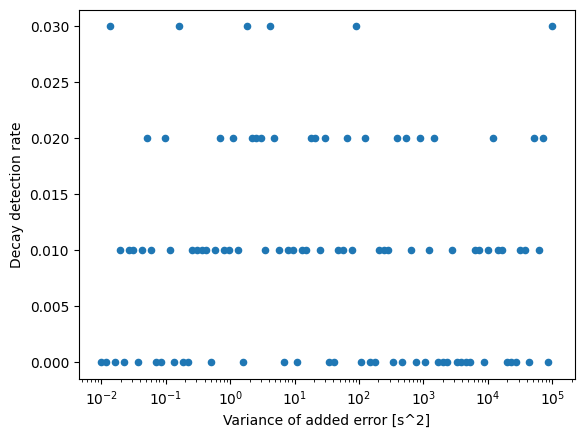

In [17]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(-2, 5, 100):  # 0.01s to 10,000s variance
    test = ({"error_name": "constant_variance_error", "var": var}, np.full(len(E), var)) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, variances, trials=100)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Variance of added error [s^2]", ylabel="Decay detection rate")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


<AxesSubplot: xlabel='Scale of variance of added error [s^2]', ylabel='Decay detection rate'>

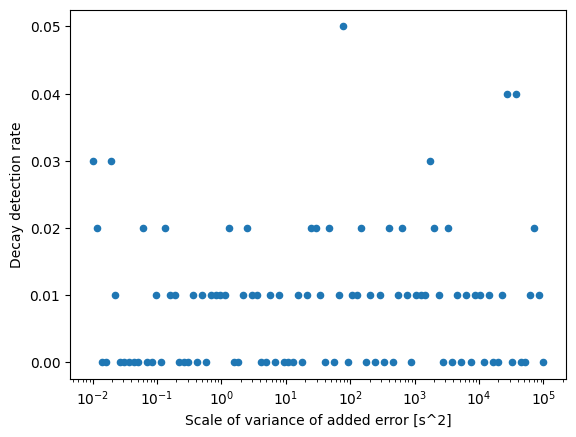

In [18]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(-2, 5, 100):  # 0.01s to 10,000s "scale of variance"
    test = ({"error_name": "constant_variance_error", "var": var}, np.diag(sp.stats.wishart.rvs(df=len(E), scale=np.full(len(E), var)))) # sp.stats.norm(loc=0, scale=sd).rvs(len(E))))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, variances, trials=100)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Scale of variance of added error [s^2]", ylabel="Decay detection rate")

#### What if the measurement errors are larger than reported?

Can we still avoid false detections?

<AxesSubplot: xlabel='Scaling of added error [s^2]', ylabel='Decay detection rate'>

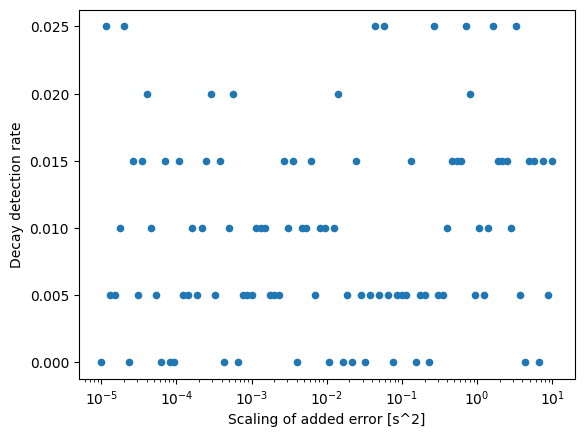

In [24]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for scaling in np.logspace(-5, 1, 100):
    test = ({"error_name": "constant_variance_error", "scaling": scaling}, np.full(len(E), 10_000)) # 10,000s variance
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, error_info["scaling"]*variances, trials=200)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="scaling", y="decay_detection_rate", logx=True, xlabel="Scaling of added error [s^2]", ylabel="Decay detection rate")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


<AxesSubplot: xlabel='Scaling of added error [s^2]', ylabel='Decay detection rate'>

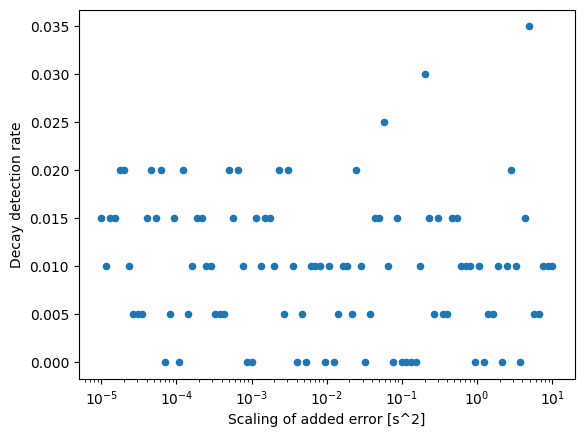

In [25]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for scaling in np.logspace(-5, 1, 100):
    test = ({"error_name": "changing_variance_error", "scaling": scaling}, np.diag(sp.stats.wishart.rvs(df=len(E), scale=np.full(len(E), 10_000)))) # 10,000s scale
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, error_info["scaling"]*variances, trials=200)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="scaling", y="decay_detection_rate", logx=True, xlabel="Scaling of added error [s^2]", ylabel="Decay detection rate")

A constant scaling has little impact. What if we scale reported errors non-uniformly?

<AxesSubplot: xlabel='Variance of added error [s^2]', ylabel='Decay detection rate'>

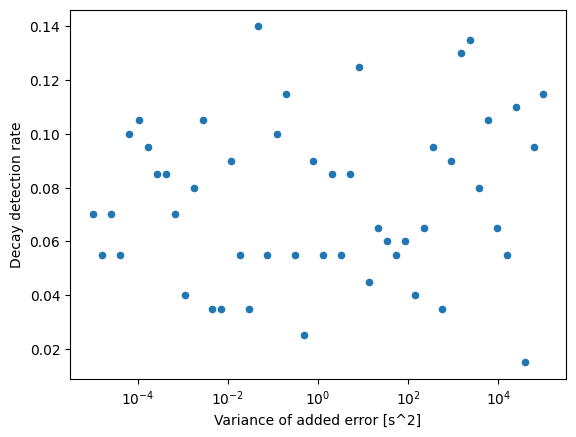

In [27]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(-5, 5, 100):
    test = ({"error_name": "constant_variance_error", "var": var, "scaling": np.random.rand(len(E))}, np.full(len(E), var))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, error_info["scaling"]*variances, trials=200)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Variance of added error [s^2]", ylabel="Decay detection rate")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.93it/s]


<AxesSubplot: xlabel='Scale of added error [s^2]', ylabel='Decay detection rate'>

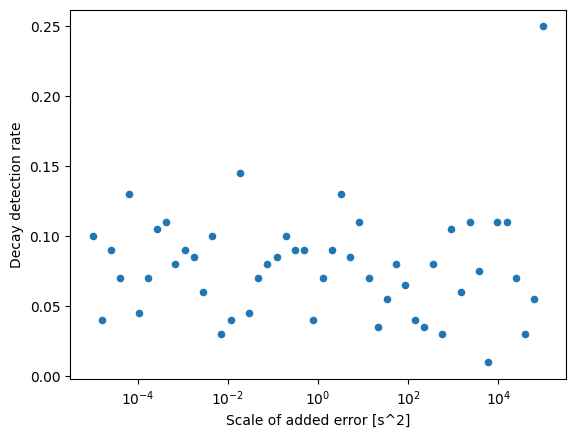

In [28]:
MODELS = []
P0 = 1.1*SECONDS_TO_DAYS
dP_dE = 0.0
test = ({"model_name": "quadratic_ephemeris", "P0": P0, "dP_dE": dP_dE}, functools.partial(quadratic_ephemeris_model, T0=0, P0=P0, dP_dE=dP_dE))
MODELS.append(test)

ERRORS = []
for var in np.logspace(-5, 5, 100):
    test = ({"error_name": "constant_variance_error", "var": var, "scaling": np.random.rand(len(E))},np.diag(sp.stats.wishart.rvs(df=len(E), scale=np.full(len(E), 10_000))))
    ERRORS.append(test)

results = []
for (model_info, model), (error_info, variances) in tqdm(list(itertools.product(MODELS, ERRORS))):
    decay_detection_rate = run_test(model, error_info["scaling"]*variances, trials=200)
    results.append({**model_info, **error_info, "decay_detection_rate": decay_detection_rate})

df = pd.DataFrame(data=results)
df.plot.scatter(x="var", y="decay_detection_rate", logx=True, xlabel="Scale of added error [s^2]", ylabel="Decay detection rate")

If we scale the reported errors non-uniformly we start to see an increased false detection rate, corresponding to situations where extra weight is being placed on particularly large outliers because their reported measurement error is small.

Does our posterior covariance better reflect the true errors?

#### Companion planets example: TOI-270

- Two outer planets are in resonance
- Inner planet exhibits a chopping signal in the TTVs
- Paper by Laurel Kyae

In [210]:
# start with exoclock's database
toi_270_data = pd.read_csv("./data/Papers/kaye_2022.csv")
toi_270_data

planet  number telescope  transit_time    error  Unnamed: 5
0    TOI-270 b       1      TESS   2458387.090  0.02110         NaN
1    TOI-270 b       2      TESS   2458390.452  0.00719         NaN
2    TOI-270 b       3      TESS   2458393.814  0.01845         NaN
3    TOI-270 b       4      TESS   2458397.169  0.02853         NaN
4    TOI-270 b       5      TESS   2458400.532  0.01164         NaN
..         ...     ...       ...           ...      ...         ...
99   TOI-270 d      63       LCO   2459095.214  0.00043         NaN
100  TOI-270 d      65      TESS   2459117.971  0.00107         NaN
101  TOI-270 d      67      TESS   2459140.731  0.00128         NaN
102  TOI-270 d      70      TESS   2459174.869  0.00136         NaN
103  TOI-270 d      72      TESS   2459197.629  0.00123         NaN

[104 rows x 6 columns]

##### TOI-270b

In [242]:
PERIOD = 3.36016
df = toi_270_data[toi_270_data.planet == 'TOI-270 b']
df = df.sort_values("transit_time").drop_duplicates(["transit_time"]).reset_index(drop=True)
df["epoch"] = ((df.transit_time - df.transit_time[0]) / PERIOD).round()
df["epoch"] = df.epoch - df.epoch.median()
df

planet  number telescope  transit_time    error  Unnamed: 5  epoch
0   TOI-270 b       1      TESS   2458387.090  0.02110         NaN  -37.0
1   TOI-270 b       2      TESS   2458390.452  0.00719         NaN  -36.0
2   TOI-270 b       3      TESS   2458393.814  0.01845         NaN  -35.0
3   TOI-270 b       4      TESS   2458397.169  0.02853         NaN  -34.0
4   TOI-270 b       5      TESS   2458400.532  0.01164         NaN  -33.0
5   TOI-270 b       6      TESS   2458403.890  0.00561         NaN  -32.0
6   TOI-270 b       9      TESS   2458413.982  0.00724         NaN  -29.0
7   TOI-270 b      10      TESS   2458417.334  0.00937         NaN  -28.0
8   TOI-270 b      13      TESS   2458427.425  0.01211         NaN  -25.0
9   TOI-270 b      15      TESS   2458434.139  0.00714         NaN  -23.0
10  TOI-270 b      17      TESS   2458440.852  0.02183         NaN  -21.0
11  TOI-270 b      18      TESS   2458444.217  0.00687         NaN  -20.0
12  TOI-270 b      19      TESS   2458447.574  0.00304         NaN  -19.0
13  TOI-270 b      22      TESS   2458457.656  0.00920         NaN  -16.0
14  TOI-270 b      23      TESS   2458461.016  0.01262         NaN  -15.0
15  TOI-270 b      34       LCO   2458497.971  0.01585         NaN   -4.0
16  TOI-270 b      37       LCO   2458508.052  0.01428         NaN   -1.0
17  TOI-270 b      38       LCO   2458511.412  0.00679         NaN    0.0
18  TOI-270 b     103      NGTS   2458729.828  0.01621         NaN   65.0
19  TOI-270 b     133       LCO   2458830.632  0.01385         NaN   95.0
20  TOI-270 b     215       LCO   2459106.169  0.00555         NaN  177.0
21  TOI-270 b     218      TESS   2459116.238  0.01181         NaN  180.0
22  TOI-270 b     219      TESS   2459119.606  0.00555         NaN  181.0
23  TOI-270 b     220      TESS   2459122.959  0.01316         NaN  182.0
24  TOI-270 b     221      TESS   2459126.325  0.00683         NaN  183.0
25  TOI-270 b     223      TESS   2459133.046  0.02103         NaN  185.0
26  TOI-270 b     224      TESS   2459136.410  0.03099         NaN  186.0
27  TOI-270 b     225      TESS   2459139.764  0.02113         NaN  187.0
28  TOI-270 b     227       LCO   2459146.486  0.01916         NaN  189.0
29  TOI-270 b     236      TESS   2459176.732  0.00293         NaN  198.0
30  TOI-270 b     237      TESS   2459180.090  0.00268         NaN  199.0
31  TOI-270 b     238      TESS   2459183.451  0.00585         NaN  200.0
32  TOI-270 b     240      TESS   2459190.166  0.00736         NaN  202.0
33  TOI-270 b     241      TESS   2459193.531  0.02524         NaN  203.0
34  TOI-270 b     242      TESS   2459196.887  0.00599         NaN  204.0

In [245]:
beta, t_sigma, error, k, t_dof, prob_decay, *_ = bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
prob_decay

0.38371564585041806

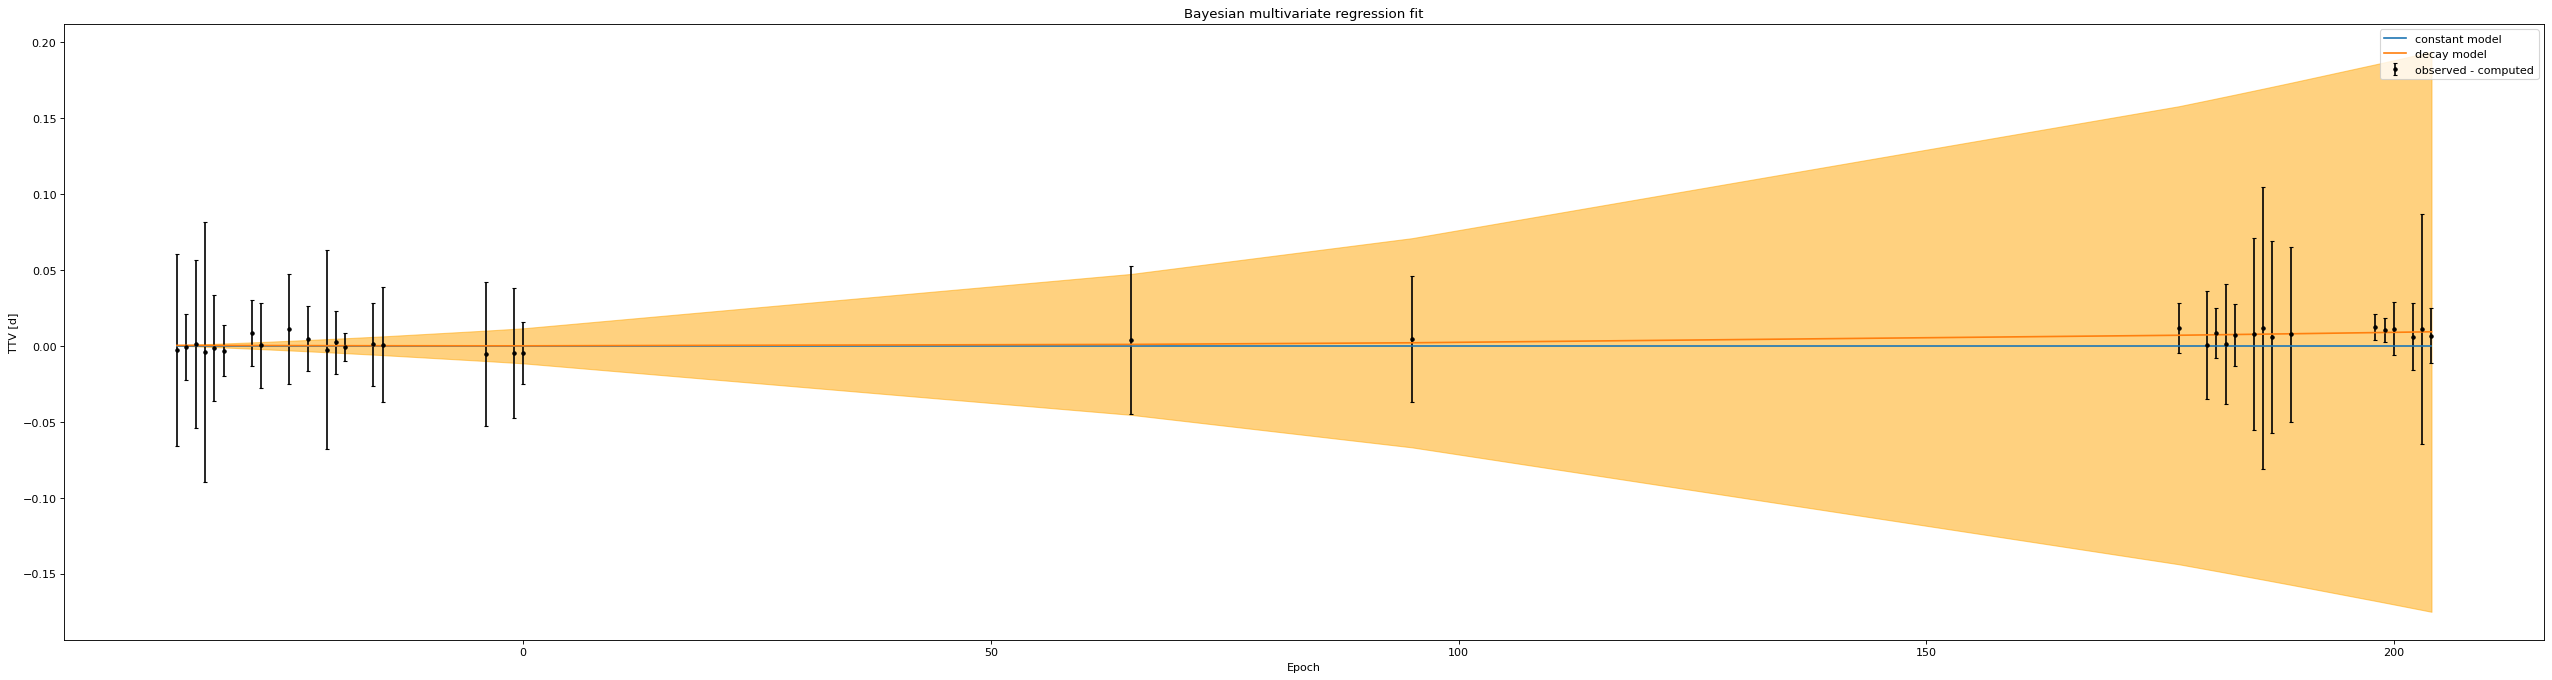

In [251]:
plt.figure(figsize=(40, 10), dpi=80)

X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0),
        0.5 * np.power(df.epoch, 2.0),
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
y_error = 3*np.atleast_2d(df.error.values).T

fit_error = 3*np.atleast_2d(np.sqrt(np.diag(t_sigma))).T
upper_fit = X@(beta+fit_error)
lower_fit = X@(beta-fit_error)

const_beta = np.copy(beta)
const_beta[2, 0] = 0
const_y = X@const_beta
decay_y = X@beta
occ = (y - const_y).flatten()
plt.errorbar(df.epoch, occ, yerr=3*df.error, fmt=".k", capsize=2, label="observed - computed")

deviation = decay_y - const_y
deviation_upper = (upper_fit - const_y).flatten()
deviation_lower = (lower_fit - const_y).flatten()

plt.plot(df.epoch, np.full(occ.shape, 0), label="constant model")
plt.plot(df.epoch, deviation, label="decay model")
# plt.ylim([-0.05, 0.05])
plt.fill_between(df.epoch, deviation_upper, deviation_lower, color='orange', alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("TTV [d]")
plt.title("Bayesian multivariate regression fit")
plt.legend()
plt.show()

##### TOI-270 c

In [252]:
PERIOD = 5.66057
df = toi_270_data[toi_270_data.planet == 'TOI-270 c']
df = df.sort_values("transit_time").drop_duplicates(["transit_time"]).reset_index(drop=True)
df["epoch"] = ((df.transit_time - df.transit_time[0]) / PERIOD).round()
df["epoch"] = df.epoch - df.epoch.median()
df

planet  number telescope  transit_time    error  Unnamed: 5  epoch
0   TOI-270 c       0      TESS   2458383.842  0.00093         NaN  -69.5
1   TOI-270 c       1      TESS   2458389.504  0.00141         NaN  -68.5
2   TOI-270 c       2      TESS   2458395.162  0.00064         NaN  -67.5
3   TOI-270 c       4      TESS   2458406.482  0.00134         NaN  -65.5
4   TOI-270 c       5      TESS   2458412.142  0.00091         NaN  -64.5
5   TOI-270 c       6      TESS   2458417.803  0.00145         NaN  -63.5
6   TOI-270 c       7      TESS   2458423.464  0.00084         NaN  -62.5
7   TOI-270 c       8      TESS   2458429.123  0.00103         NaN  -61.5
8   TOI-270 c       9      TESS   2458434.784  0.00101         NaN  -60.5
9   TOI-270 c      10      TESS   2458440.444  0.00155         NaN  -59.5
10  TOI-270 c      11      TESS   2458446.104  0.00094         NaN  -58.5
11  TOI-270 c      12      TESS   2458451.765  0.00128         NaN  -57.5
12  TOI-270 c      13      TESS   2458457.428  0.00394         NaN  -56.5
13  TOI-270 c      14       LCO   2458463.084  0.00033         NaN  -55.5
14  TOI-270 c      19       LCO   2458491.385  0.00043         NaN  -50.5
15  TOI-270 c      33     ASTEP   2458570.633  0.00149         NaN  -36.5
16  TOI-270 c      37   Spitzer   2458593.273  0.00018         NaN  -32.5
17  TOI-270 c      55  TRAPPIST   2458695.162  0.00085         NaN  -14.5
18  TOI-270 c      61  TRAPPIST   2458729.124  0.00067         NaN   -8.5
19  TOI-270 c      61       LCO   2458729.125  0.00036         NaN   -8.5
20  TOI-270 c      63       LCO   2458740.448  0.00056         NaN   -6.5
21  TOI-270 c      66       LCO   2458757.429  0.00031         NaN   -3.5
22  TOI-270 c      69       LCO   2458774.410  0.00040         NaN   -0.5
23  TOI-270 c      70  TRAPPIST   2458780.070  0.00096         NaN    0.5
24  TOI-270 c      72       LCO   2458791.394  0.00033         NaN    2.5
25  TOI-270 c      73       LCO   2458797.054  0.00035         NaN    3.5
26  TOI-270 c      74       LCO   2458802.714  0.00036         NaN    4.5
27  TOI-270 c      77       LCO   2458819.695  0.00128         NaN    7.5
28  TOI-270 c      78   Spitzer   2458825.357  0.00019         NaN    8.5
29  TOI-270 c      81   Spitzer   2458842.339  0.00014         NaN   11.5
30  TOI-270 c      83   Spitzer   2458853.661  0.00015         NaN   13.5
31  TOI-270 c      84   Spitzer   2458859.322  0.00013         NaN   14.5
32  TOI-270 c     107     ASTEP   2458989.518  0.00113         NaN   37.5
33  TOI-270 c     108     ASTEP   2458995.176  0.00200         NaN   38.5
34  TOI-270 c     110     ASTEP   2459006.502  0.00106         NaN   40.5
35  TOI-270 c     129      TESS   2459114.054  0.00072         NaN   59.5
36  TOI-270 c     130      TESS   2459119.714  0.00100         NaN   60.5
37  TOI-270 c     131      TESS   2459125.374  0.00076         NaN   61.5
38  TOI-270 c     132      TESS   2459131.037  0.00071         NaN   62.5
39  TOI-270 c     135       LCO   2459148.017  0.00029         NaN   65.5
40  TOI-270 c     139      TESS   2459170.659  0.00090         NaN   69.5
41  TOI-270 c     140      TESS   2459176.319  0.00081         NaN   70.5
42  TOI-270 c     141      TESS   2459181.981  0.00101         NaN   71.5
43  TOI-270 c     142      TESS   2459187.640  0.00092         NaN   72.5
44  TOI-270 c     143      TESS   2459193.302  0.00129         NaN   73.5
45  TOI-270 c     147       LCO   2459215.940  0.00112         NaN   77.5

In [254]:
beta, t_sigma, error, k, t_dof, prob_decay, *_ = bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
prob_decay

8.472369157210125e-33

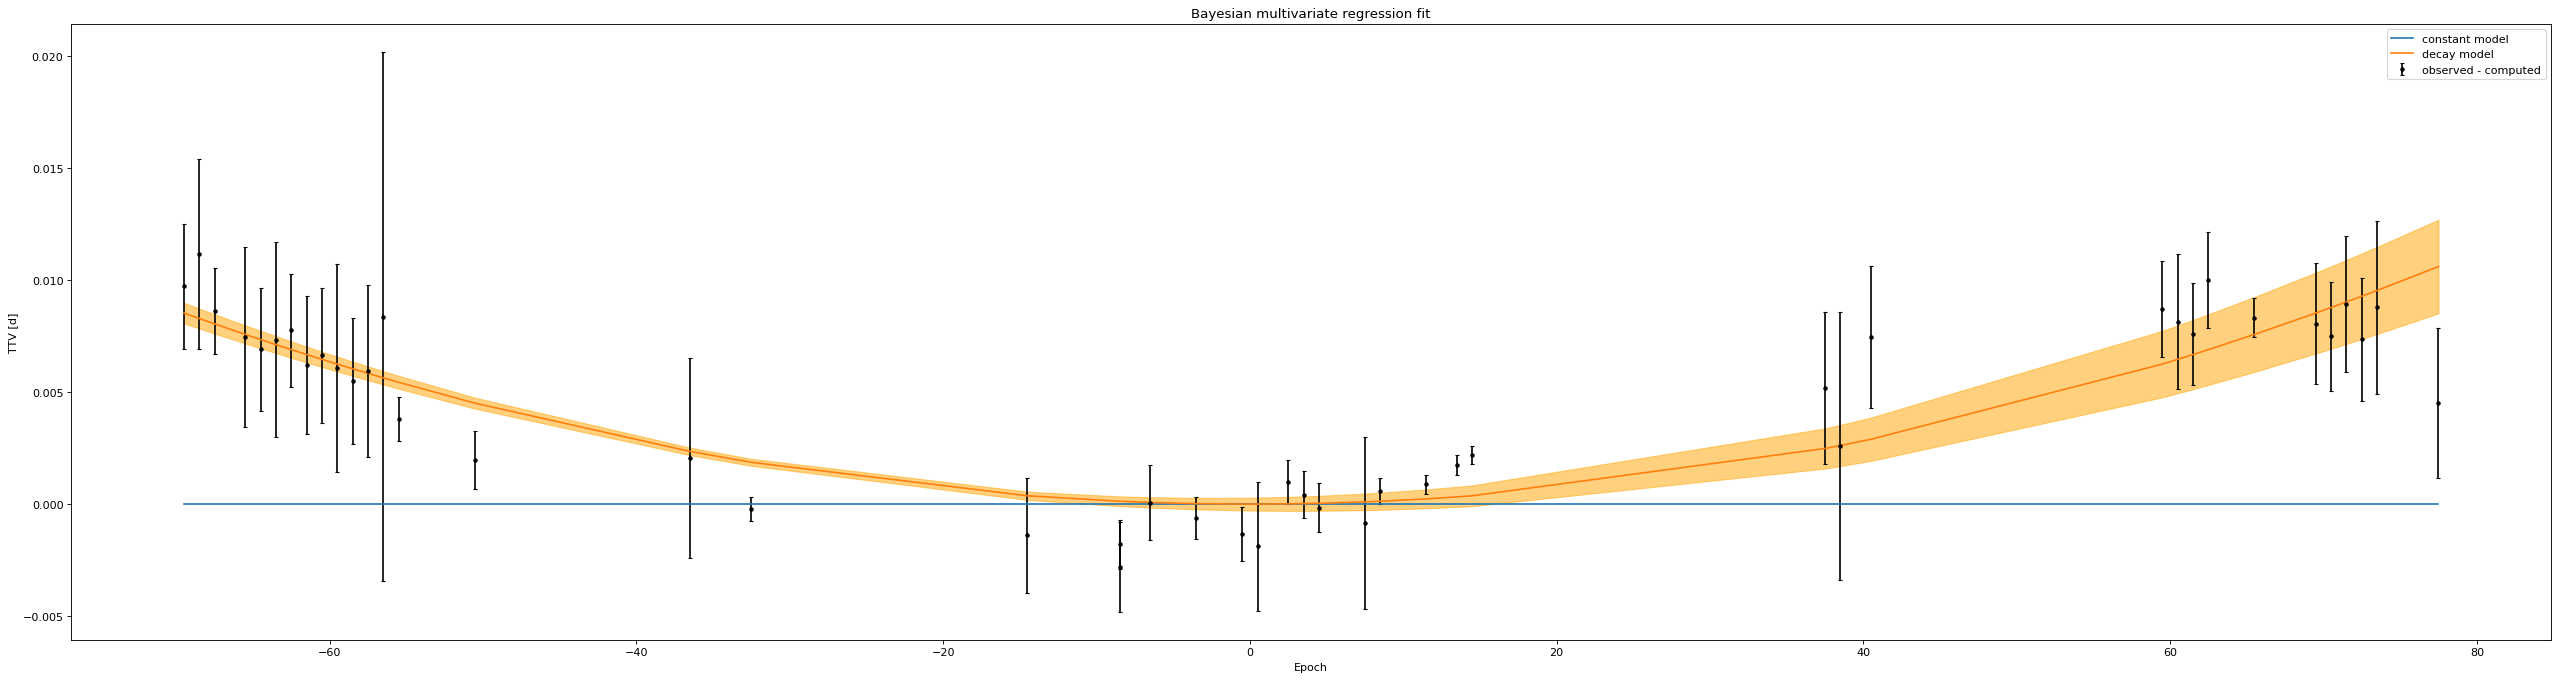

In [255]:
plt.figure(figsize=(40, 10), dpi=80)

X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0),
        0.5 * np.power(df.epoch, 2.0),
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
y_error = 3*np.atleast_2d(df.error.values).T

fit_error = 3*np.atleast_2d(np.sqrt(np.diag(t_sigma))).T
upper_fit = X@(beta+fit_error)
lower_fit = X@(beta-fit_error)

const_beta = np.copy(beta)
const_beta[2, 0] = 0
const_y = X@const_beta
decay_y = X@beta
occ = (y - const_y).flatten()
plt.errorbar(df.epoch, occ, yerr=3*df.error, fmt=".k", capsize=2, label="observed - computed")

deviation = decay_y - const_y
deviation_upper = (upper_fit - const_y).flatten()
deviation_lower = (lower_fit - const_y).flatten()

plt.plot(df.epoch, np.full(occ.shape, 0), label="constant model")
plt.plot(df.epoch, deviation, label="decay model")
# plt.ylim([-0.05, 0.05])
plt.fill_between(df.epoch, deviation_upper, deviation_lower, color='orange', alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("TTV [d]")
plt.title("Bayesian multivariate regression fit")
plt.legend()
plt.show()

##### TOI-270 d

In [257]:
PERIOD = 11.37958
df = toi_270_data[toi_270_data.planet == 'TOI-270 d']
df = df.sort_values("transit_time").drop_duplicates(["transit_time"]).reset_index(drop=True)
df["epoch"] = ((df.transit_time - df.transit_time[0]) / PERIOD).round()
df["epoch"] = df.epoch - df.epoch.median()
df

planet  number telescope  transit_time    error  Unnamed: 5  epoch
0   TOI-270 d       1      TESS   2458389.679  0.00118         NaN  -33.5
1   TOI-270 d       2      TESS   2458401.058  0.00158         NaN  -32.5
2   TOI-270 d       3      TESS   2458412.436  0.00614         NaN  -31.5
3   TOI-270 d       5      TESS   2458435.198  0.00098         NaN  -29.5
4   TOI-270 d       6      TESS   2458446.580  0.00203         NaN  -28.5
5   TOI-270 d       7      TESS   2458457.959  0.00449         NaN  -27.5
6   TOI-270 d      14       LCO   2458537.618  0.00075         NaN  -20.5
7   TOI-270 d      24   Spitzer   2458651.417  0.00025         NaN  -10.5
8   TOI-270 d      33       LCO   2458753.830  0.00033         NaN   -1.5
9   TOI-270 d      33      NGTS   2458753.833  0.00125         NaN   -1.5
10  TOI-270 d      34       LCO   2458765.212  0.00047         NaN   -0.5
11  TOI-270 d      35       LCO   2458776.591  0.00071         NaN    0.5
12  TOI-270 d      38      NGTS   2458810.727  0.00083         NaN    3.5
13  TOI-270 d      38  TRAPPIST   2458810.732  0.00142         NaN    3.5
14  TOI-270 d      39   Spitzer   2458822.109  0.00023         NaN    4.5
15  TOI-270 d      42   Spitzer   2458856.248  0.00024         NaN    7.5
16  TOI-270 d      59       LCO   2459049.697  0.00070         NaN   24.5
17  TOI-270 d      63       LCO   2459095.214  0.00043         NaN   28.5
18  TOI-270 d      65      TESS   2459117.971  0.00107         NaN   30.5
19  TOI-270 d      67      TESS   2459140.731  0.00128         NaN   32.5
20  TOI-270 d      70      TESS   2459174.869  0.00136         NaN   35.5
21  TOI-270 d      72      TESS   2459197.629  0.00123         NaN   37.5

In [258]:
beta, t_sigma, error, k, t_dof, prob_decay, *_ = bayesian_mvn_regression_fit(df, K0=np.diag([1e-12, 1e-12, 1e-12]))
prob_decay

0.9999999999635807

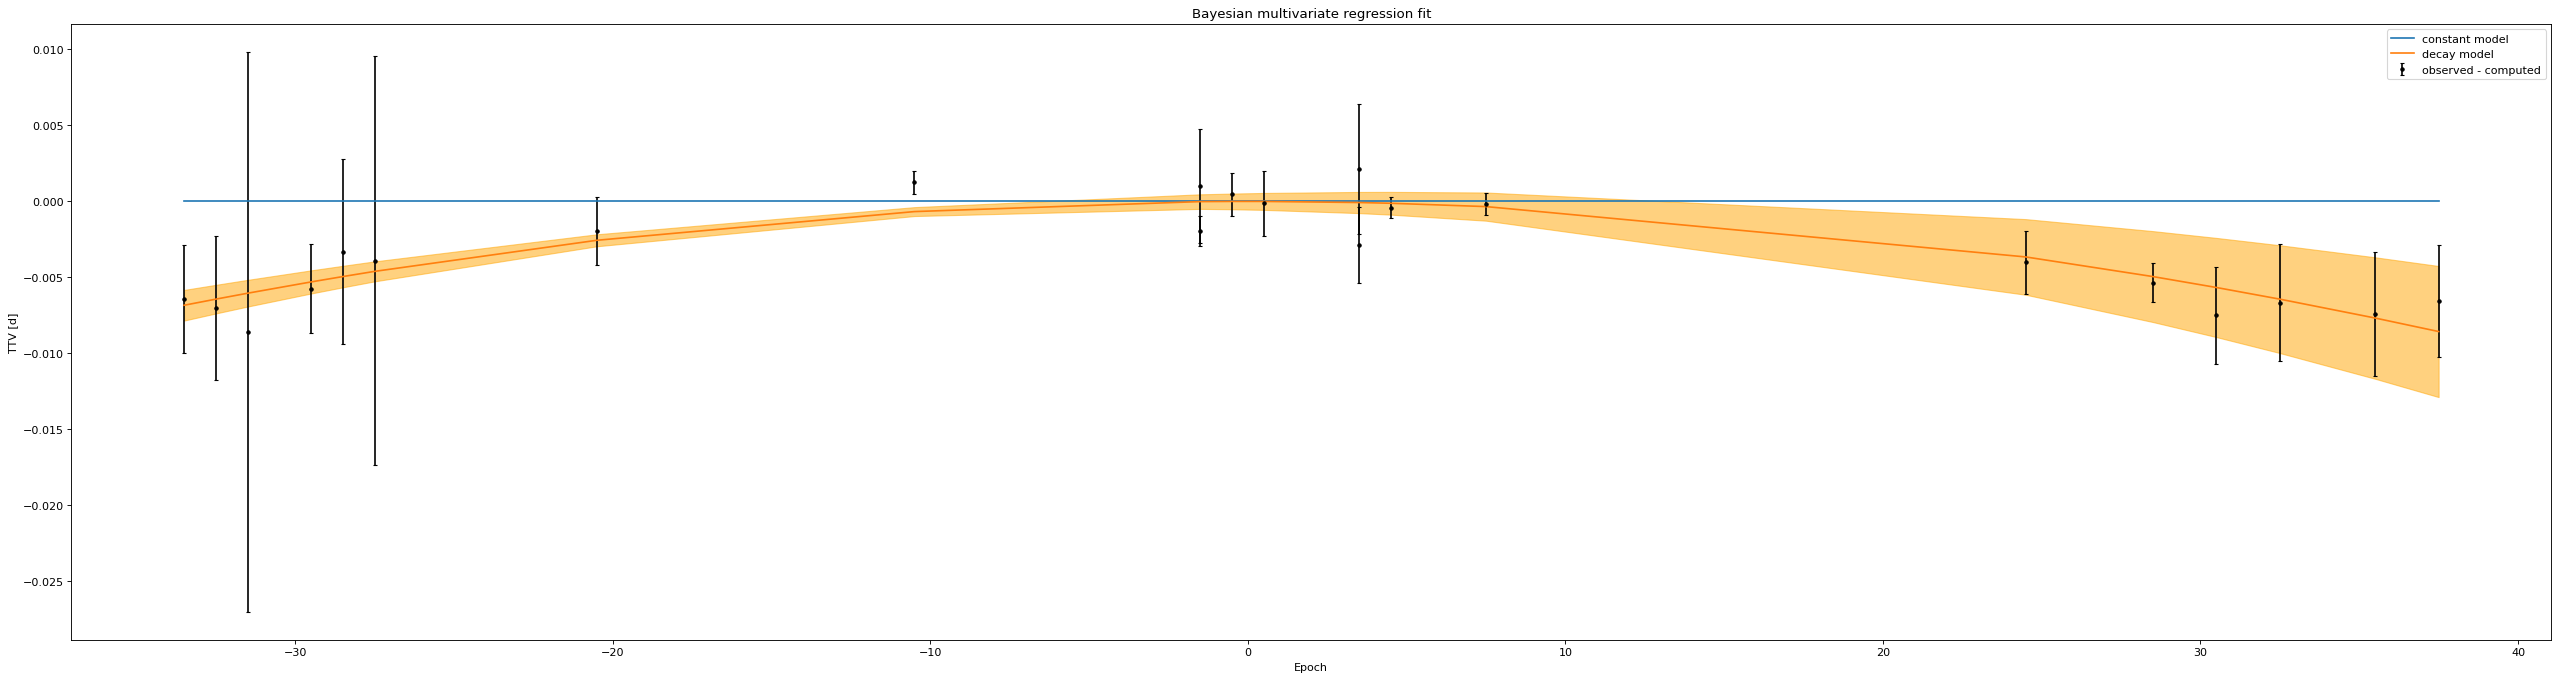

In [259]:
plt.figure(figsize=(40, 10), dpi=80)

X = np.vstack(
    [
        np.power(df.epoch, 0.0),
        np.power(df.epoch, 1.0),
        0.5 * np.power(df.epoch, 2.0),
    ]
).T
y = np.atleast_2d(df.transit_time.values).T
y_error = 3*np.atleast_2d(df.error.values).T

fit_error = 3*np.atleast_2d(np.sqrt(np.diag(t_sigma))).T
upper_fit = X@(beta+fit_error)
lower_fit = X@(beta-fit_error)

const_beta = np.copy(beta)
const_beta[2, 0] = 0
const_y = X@const_beta
decay_y = X@beta
occ = (y - const_y).flatten()
plt.errorbar(df.epoch, occ, yerr=3*df.error, fmt=".k", capsize=2, label="observed - computed")

deviation = decay_y - const_y
deviation_upper = (upper_fit - const_y).flatten()
deviation_lower = (lower_fit - const_y).flatten()

plt.plot(df.epoch, np.full(occ.shape, 0), label="constant model")
plt.plot(df.epoch, deviation, label="decay model")
# plt.ylim([-0.05, 0.05])
plt.fill_between(df.epoch, deviation_upper, deviation_lower, color='orange', alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("TTV [d]")
plt.title("Bayesian multivariate regression fit")
plt.legend()
plt.show()

In [311]:
365 * 24 * 60 * 60 / (2*np.pi)

5019110.285346012

In [312]:
12 * 60 * 60

43200

Interestingly we do pick up the outer planet d as a decay.

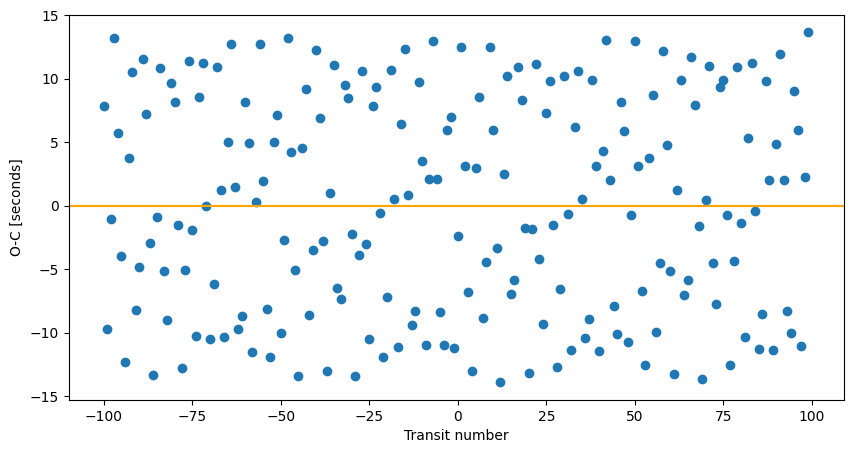

In [366]:
E = np.arange(-100, 100) # it's ok to generate two of the same epoch, that would correpsond to two independent observations of the same transit

def toi_270_model(E, planet_idx=1):
    star_idx = 0

    sim = rebound.Simulation()
    sim.add(m=1)  # star
    sim.add(m=1.58 * earth_mass / solar_mass, a=0.03197,e=0.034)
    sim.add(m=6.15 * earth_mass / solar_mass, a=0.04526, e=0.027)
    sim.add(m=4.78 * earth_mass / solar_mass, a=0.07210, e=0.032)

    sim.move_to_com()

    # timestep of 2*pi = 1 Earth-like orbit if mass = solar mass and a = earth semi-major axis i.e. 1 AU
    # time unit = 365 * 24 * 60 * 60 / (2*np.pi) = 58.09 days
    timestep_to_seconds = 365 * 24 * 60 * 60 / (2*np.pi)
    integrate_timestep = 2 * 24 * 60 * 60 / timestep_to_seconds # 4 hours in simulation time units

    # note each call to .integrate is an independent run of the simulation
    E_copy = E + abs(min(E))
    N = max(E_copy) + 1
    transits = np.zeros(N)
    p = sim.particles
    i = 0
    while i < N:
        y_old = p[planet_idx].y - p[star_idx].y
        t_old = sim.t
        sim.integrate(sim.t+integrate_timestep) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p[planet_idx].y-p[star_idx].y)<0. and p[planet_idx].x-p[star_idx].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-9:   # bisect until prec of 1e-7 reached
                if y_old*(p[planet_idx].y-p[star_idx].y)<0.:  # if we have crossed the y axis
                    t_new = sim.t
                else:  # if we have not crossed the y axis
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)  # integrate up to halfway between the current time and the new time
            transits[i] = sim.t
            i += 1
            sim.integrate(sim.t+integrate_timestep)       # integrate 0.05 to be past the transit 
    
    return transits[E_copy] * timestep_to_seconds

transits = toi_270_model(E, planet_idx=1)
plot_transits(transits, E)

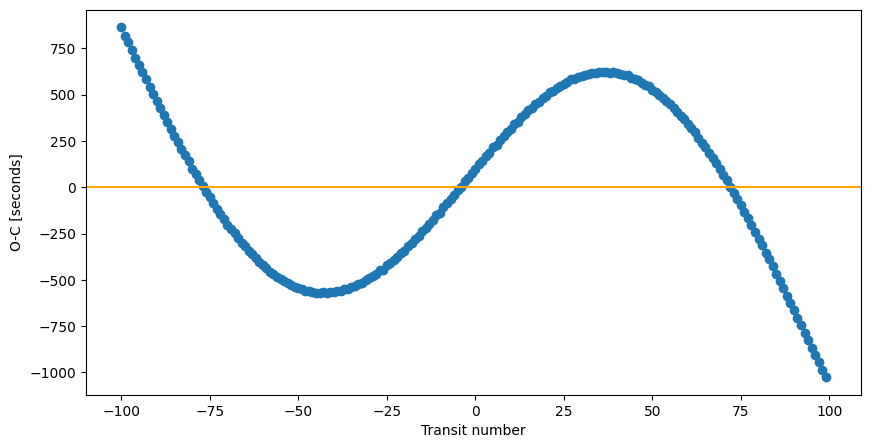

In [367]:
transits = toi_270_model(E, planet_idx=2)
plot_transits(transits, E)

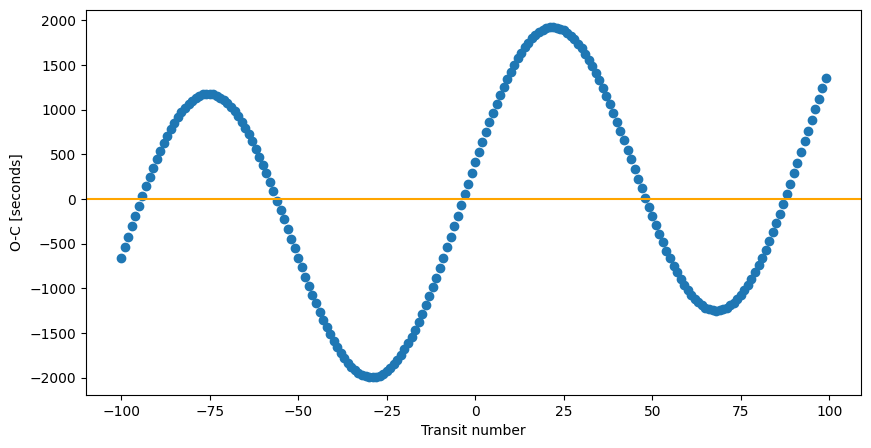

In [368]:
transits = toi_270_model(E, planet_idx=3)
plot_transits(transits, E)

What about a stellar-size companion?